In [ ]:
!pip install pgmpy
import numpy as np
import matplotlib.pyplot as plt
from pgmpy.factors.discrete import State
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
from pgmpy.sampling import BayesianModelSampling

# Compare values down to 3rd digit
precision = 3

# Defining the network structure
weather = BayesianModel([('Cloudy', 'Rain'), ('Cloudy', 'Sprinkler'), ('Sprinkler', 'WetGrass'), ('Rain', 'WetGrass')])

# Defining the CPDs:
cpd_cloudy = TabularCPD('Cloudy', 2, [[.5],[.5]])
cpd_sprinkler = TabularCPD('Sprinkler', 2, [[.1,.5],[.9,.5]], evidence = ['Cloudy'], evidence_card=[2])
cpd_rain = TabularCPD('Rain', 2, [[.8,.2],[.2,.8]], evidence = ['Cloudy'], evidence_card=[2])
cpd_wetgrass = TabularCPD('WetGrass', 2, [[.99,.9,.9,.01],[.01,.1,.1,.99]], evidence = ['Sprinkler','Rain'], evidence_card=[2,2])

weather.add_cpds(cpd_cloudy,cpd_sprinkler,cpd_rain,cpd_wetgrass)
# weather.get_cpds()
weather.check_model()

# Exact values of queries (for comparison)
inference = VariableElimination(weather)
pcloudy = inference.query(['Cloudy'],{'Sprinkler':1,'WetGrass':1}).values[1]
# print('P(Cloudy=true|Sprinkler=true,WetGrass=true) = ', round(pcloudy,precision))
prain = inference.query(['Rain'],{'Sprinkler':1,'WetGrass':1}).values[1]
# print('P(Rain=true|Sprinkler=true,WetGrass=true) = ', round(prain,precision))


/usr/local/lib/python3.7/dist-packages/pgmpy/models/BayesianModel.py:10: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  FutureWarning,


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
# Now switch to sampling methods
inference = BayesianModelSampling(weather)
evidence = [State('WetGrass', 1),State('Sprinkler', 1)]
verbose = False

def prob_LW(samples,variable):
    return round(np.sum(np.dot(samples[variable],samples['_weight']))/np.sum(samples['_weight']),2)

def relative_error(exact_value,approx_value):
    return np.absolute((exact_value-approx_value)/exact_value)

def absolute_error(exact_value,approx_value):
    return np.absolute(exact_value-approx_value)

def run_experiment(sample_size):
    # Sample
    samples_LW = inference.likelihood_weighted_sample(evidence = evidence, size=sample_size)
    samples_RS = inference.rejection_sample(evidence=evidence, size=sample_size)

    # Statistics
    pcloudy_LW=prob_LW(samples_LW,'Cloudy')
    prain_LW=prob_LW(samples_LW,'Rain')
    pcloudy_RS=np.mean(samples_RS['Cloudy'], axis=0)
    prain_RS=np.mean(samples_RS['Rain'], axis=0)
    
    # Reporting
    if(verbose):
        print()
        print("P(Cloudy=true|Sprinkler=true,WetGrass=true) =", round(pcloudy,precision))
        print("With Rejection Sampling after %d samples: %.3f (error = %.2f percent)" 
              % (sample_size, pcloudy_RS, absolute_error(pcloudy,pcloudy_RS)*100))
        print("With Likelihood Weighting after %d samples: %.3f (error = %.2f percent)" 
              % (sample_size, pcloudy_LW, absolute_error(pcloudy,pcloudy_LW)*100))
        print()
        print("P(Rain=true|Sprinkler=true,WetGrass=true) =", round(prain,precision))
        print("With Rejection Sampling after %d samples: %.3f (error = %.2f percent)" 
              % (sample_size, prain_RS, absolute_error(prain,prain_RS)*100))
        print("With Likelihood Weighting after %d samples: %.3f (error = %.2f percent)" 
              % (sample_size, prain_LW, absolute_error(prain,prain_LW)*100))
    
    # Return results
    return np.array([(sample_size, 
                      pcloudy_RS, absolute_error(pcloudy,pcloudy_RS),
                      pcloudy_LW, absolute_error(pcloudy,pcloudy_LW),
                      prain_RS, absolute_error(prain,prain_RS),
                      prain_LW, absolute_error(prain,prain_LW))], 
                    dtype=[('sample_size', '<i8'), 
                           ('pcloudy_RS', '<f8'),('e_pcloudy_RS', '<f8'),
                           ('pcloudy_LW', '<f8'),('e_pcloudy_LW', '<f8'),
                           ('prain_RS', '<f8'),('e_prain_RS', '<f8'),
                           ('prain_LW', '<f8'),('e_prain_LW', '<f8')])

# To view samples
# print(samples_LW)
# samples_LW.view()
# print(samples_RS[:5]), print(' ... '), print(samples_RS[nsamples_RS-5:])

In [9]:
results = np.array([],dtype=[('sample_size', '<i8'), 
                             ('pcloudy_RS', '<f8'),('e_pcloudy_RS', '<f8'),
                             ('pcloudy_LW', '<f8'),('e_pcloudy_LW', '<f8'),
                             ('prain_RS', '<f8'),('e_prain_RS', '<f8'),
                             ('prain_LW', '<f8'),('e_prain_LW', '<f8')])
starting_size_=1 # from 10 sample points
final_size=5     # to 10^5 sample points
experiments=20 # 8 experiments

for size in np.logspace(starting_size_, final_size, num=experiments, dtype='<i8'):
    results=np.append(results,run_experiment(size))
    
print(results)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/297 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/483 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/784 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1274 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2069 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3359 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5455 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/8858 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/14384 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/23357 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/37926 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/61584 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

[(    10, 0.7       , 0.08128619, 0.62, 0.00128619, 0.7       , 0.1750381 , 0.59, 0.2850381)
 (    16, 0.5625    , 0.05621381, 0.59, 0.02871381, 0.8125    , 0.0625381 , 0.89, 0.0149619)
 (    26, 0.53846154, 0.08025227, 0.46, 0.15871381, 0.84615385, 0.02888425, 0.9 , 0.0249619)
 (    42, 0.61904762, 0.00033381, 0.69, 0.07128619, 0.97619048, 0.10115238, 0.88, 0.0049619)
 (    69, 0.57971014, 0.03900366, 0.71, 0.09128619, 0.84057971, 0.03445839, 0.91, 0.0349619)
 (   112, 0.61607143, 0.00264238, 0.59, 0.02871381, 0.92857143, 0.05353333, 0.87, 0.0050381)
 (   183, 0.52459016, 0.09412364, 0.68, 0.06128619, 0.84699454, 0.02804356, 0.88, 0.0049619)
 (   297, 0.59259259, 0.02612121, 0.62, 0.00128619, 0.86195286, 0.01308524, 0.87, 0.0050381)
 (   483, 0.61904762, 0.00033381, 0.63, 0.01128619, 0.89026915, 0.01523105, 0.88, 0.0049619)
 (   784, 0.58418367, 0.03453013, 0.6 , 0.01871381, 0.87755102, 0.00251292, 0.88, 0.0049619)
 (  1274, 0.63736264, 0.01864883, 0.62, 0.00128619, 0.88147567, 0.0064

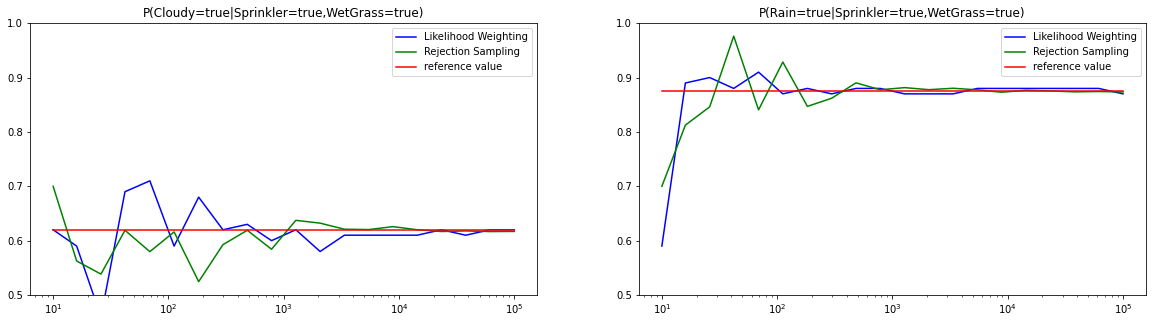

In [10]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.ylim(0.5,1)
plt.title('P(Cloudy=true|Sprinkler=true,WetGrass=true)')
LWCplot, = plt.semilogx(results['sample_size'],results['pcloudy_LW'],'b',label="Likelihood Weighting")
RSCplot, = plt.semilogx(results['sample_size'],results['pcloudy_RS'],'g',label="Rejection Sampling")
VECplot, = plt.semilogx(results['sample_size'],pcloudy*np.ones(results.size),'r',label="reference value")
plt.legend(handles=[LWCplot,RSCplot,VECplot])
plt.subplot(122)
plt.ylim(0.5,1)
plt.title('P(Rain=true|Sprinkler=true,WetGrass=true)')
LWCplot, = plt.semilogx(results['sample_size'],results['prain_LW'],'b',label="Likelihood Weighting")
RSCplot, = plt.semilogx(results['sample_size'],results['prain_RS'],'g',label="Rejection Sampling")
VECplot, = plt.semilogx(results['sample_size'],prain*np.ones(results.size),'r',label="reference value")
plt.legend(handles=[LWCplot,RSCplot,VECplot])
plt.show()

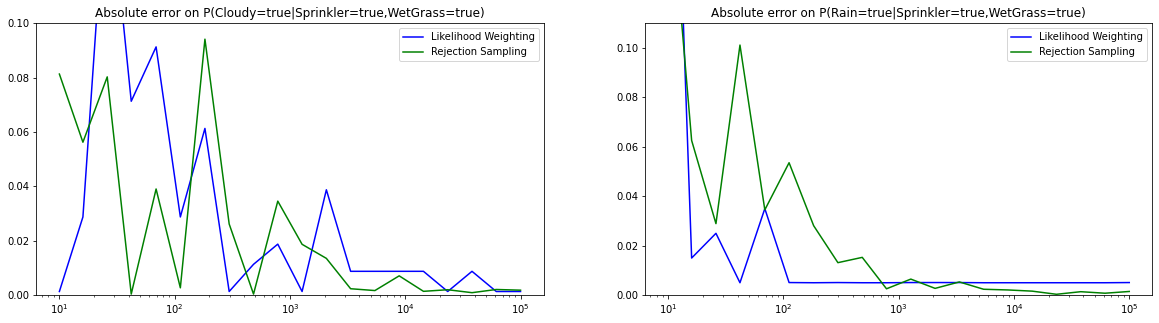

In [11]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.ylim(0,.1)
plt.title('Absolute error on P(Cloudy=true|Sprinkler=true,WetGrass=true)')
ELWCplot, = plt.semilogx(results['sample_size'],results['e_pcloudy_LW'],'b',label="Likelihood Weighting")
ERSCplot, = plt.semilogx(results['sample_size'],results['e_pcloudy_RS'],'g',label="Rejection Sampling")
plt.legend(handles=[ELWCplot,ERSCplot])
plt.subplot(122)
plt.ylim(0,.11)
plt.title('Absolute error on P(Rain=true|Sprinkler=true,WetGrass=true)')
ELWCplot, = plt.semilogx(results['sample_size'],results['e_prain_LW'],'b',label="Likelihood Weighting")
ERSCplot, = plt.semilogx(results['sample_size'],results['e_prain_RS'],'g',label="Rejection Sampling")
plt.legend(handles=[ELWCplot,ERSCplot])
plt.show()

In [12]:
weather.get_markov_blanket('Cloudy')

['Sprinkler', 'Rain']

In [13]:
weather.get_markov_blanket('Rain')

['WetGrass', 'Sprinkler', 'Cloudy']